In [2]:
!pip install opencv-python

In [3]:
!pip install pycocotools

In [4]:
from fastai.vision.core import *
from fastai.vision.utils import *
from fastai.vision.augment import *
from fastai.data.core import *
from fastai.data.transforms import *
from fastai.vision.all import *

from pycocotools.coco import COCO
import cv2
import os
from tqdm import tqdm

In [5]:
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if kaggle:
    data_dir = "/kaggle/input"
else:
    data_dir = os.getcwd() + "/data"

In [6]:
train_image_path = data_dir + "/train/images"
train_mask_path = data_dir + "/train/masks/"

## Prepare data

In [7]:
train_coco = COCO(data_dir + "/train/annotations.json")

loading annotations into memory...
Done (t=1.70s)
creating index...
index created!


In [8]:
def load_imgs(coco, category_names):
    cat_ids = coco.getCatIds(catNms=category_names) if len(category_names) > 0 else coco.getCatIds()

    cats = coco.loadCats(cat_ids)
    cats_by_id = dict(zip(cat_ids, cats))

    all_imgs = {}
    for id in cats_by_id:
        img_ids = coco.getImgIds(catIds=[id])
        imgs = coco.loadImgs(img_ids)
        for img in imgs:
            if img["id"] not in all_imgs:
                all_imgs[img["id"]] = {
                    "data": img,
                    "cats": [cats_by_id[id]["name"]]
                }
            else:
                all_imgs[img["id"]]["cats"].append(cats_by_id[id]["name"])

    return all_imgs

In [9]:
def create_masks(maskpath, coco_anns, image_ids):
    mask_path = maskpath
    if os.path.exists(mask_path):
        print('Masks already created')
    else:
        os.mkdir(mask_path)

        img_info = coco_anns.loadImgs(image_ids)

        for i in tqdm(range(len(img_info))):
            ann_ids = coco_anns.getAnnIds(imgIds=img_info[i]['id'])
            anns = coco_anns.loadAnns(ann_ids)
            
            mask = coco_anns.annToMask(anns[0])
            
            for j in range(len(anns)):
                mask += coco_anns.annToMask(anns[j]) * j
            
            cv2.imwrite(mask_path+f'{img_info[i]["file_name"]}', mask)

In [10]:
categories = ["apple", "banana"]

imgs = load_imgs(train_coco, categories)
img_names = [val["data"]["file_name"] for val in imgs.values()]

In [11]:
create_masks(train_mask_path, train_coco, imgs.keys())

Masks already created


## Training

### With masks (does not work yet)

In [12]:
def get_items(x):
    return [i for i in imgs]

getters = [
    lambda x: train_image_path + "/" + imgs[x]["data"]["file_name"],
    lambda x: imgs[x]["cats"],
    lambda x: train_mask_path + imgs[x]["data"]["file_name"],
]

item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [13]:
foodcoco = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock, MaskBlock),
    get_items=get_items,
    getters=getters,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    n_inp=1
)

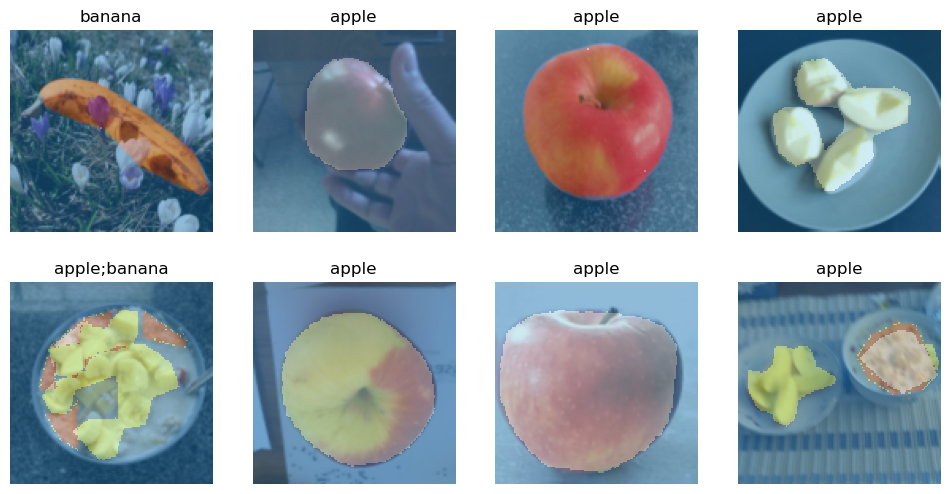

In [14]:
dls = foodcoco.dataloaders(train_image_path, bs=8)
dls.show_batch()

In [18]:
# train

### Without masks

In [15]:
def get_items(x):
    return [i for i in imgs]

getters = [
    lambda x: train_image_path + "/" + imgs[x]["data"]["file_name"],
    lambda x: imgs[x]["cats"],
]

item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [16]:
foodcoco = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_items,
    getters=getters,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    n_inp=1
)

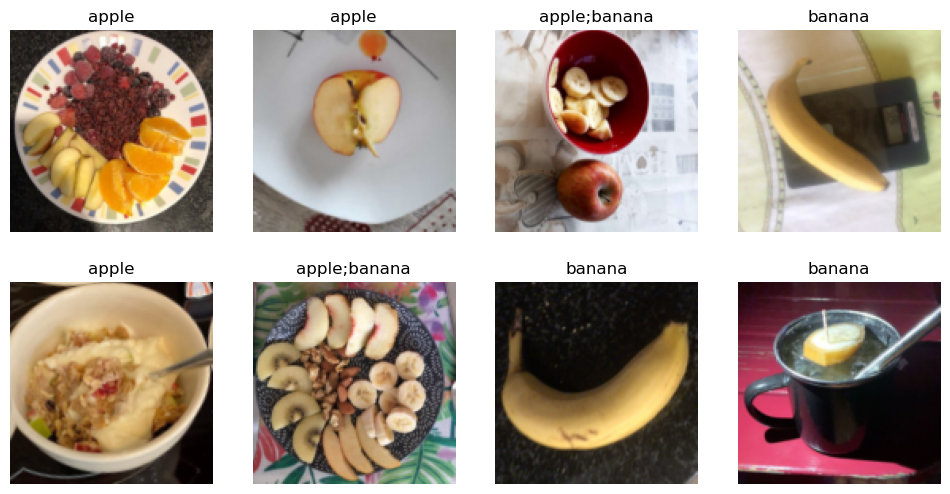

In [17]:
dls = foodcoco.dataloaders(train_image_path, bs=8)
dls.show_batch()

In [20]:
learn = vision_learner(dls, resnet34, metrics=accuracy_multi)
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.587922,0.341932,0.844371,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.465333,0.289106,0.884106,00:59


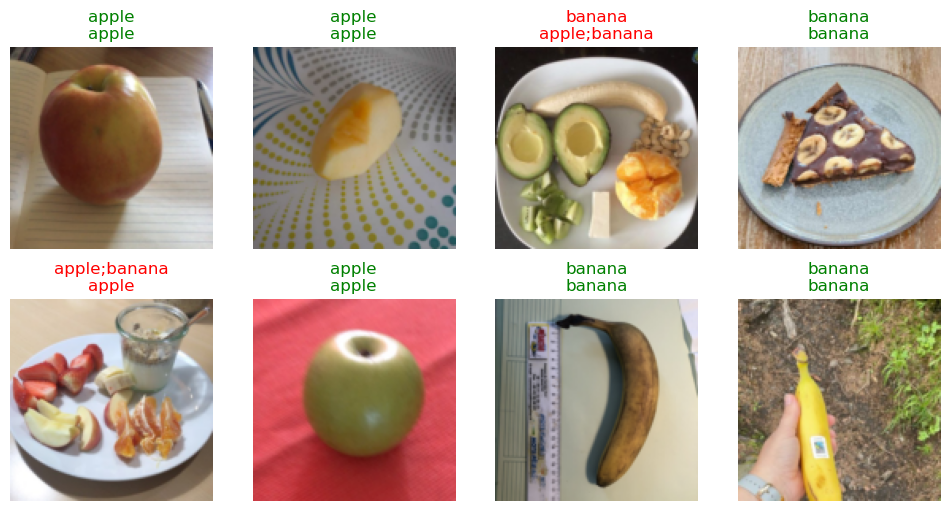

In [30]:
learn.show_results()

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,banana,apple,"tensor([9.9999e-01, 2.9640e-04])",10.112431526184082
1,banana,apple,"tensor([0.9913, 0.0287])",4.1451849937438965
2,apple,banana,"tensor([0.0174, 0.8848])",3.1071362495422363
3,apple,banana,"tensor([0.0529, 0.9461])",2.929563283920288
4,apple,banana,"tensor([0.0277, 0.8511])",2.7464442253112793
5,apple,banana,"tensor([0.1322, 0.9584])",2.6009531021118164
6,apple,banana,"tensor([0.0935, 0.8967])",2.3198211193084717
7,apple;banana,apple,"tensor([0.9982, 0.0143])",2.126335620880127


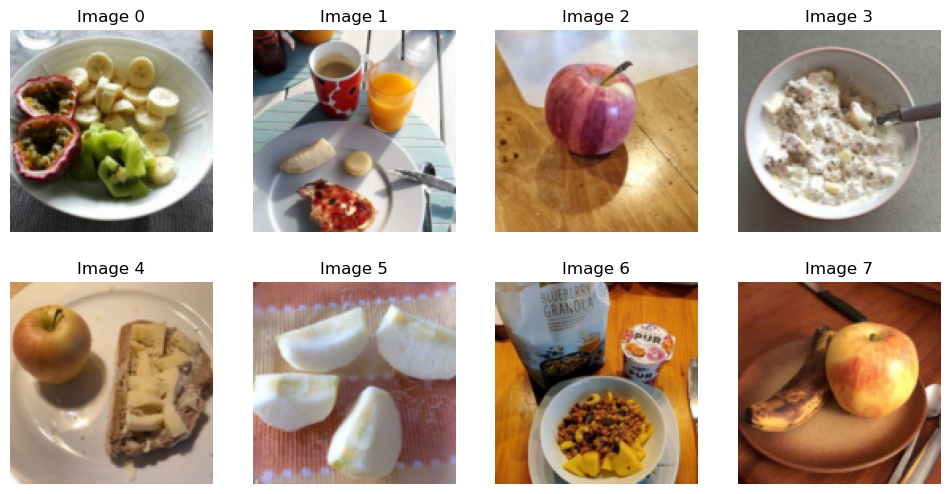

In [23]:
interp.plot_top_losses(8)

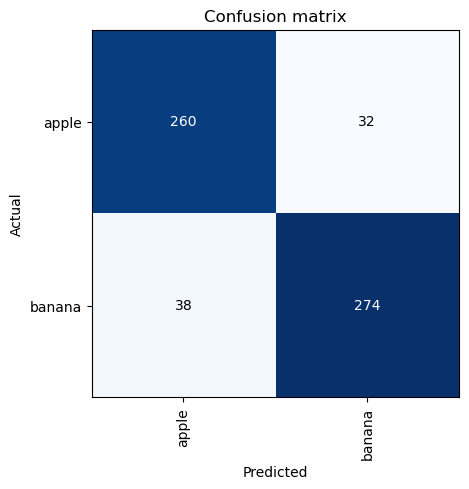

In [24]:
interp.plot_confusion_matrix()